## imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense,LSTM,Dropout,Activation,BatchNormalization,Conv1D,MaxPooling1D,Flatten
from sklearn.metrics import mean_squared_error


### Load Dataset
##### the following dataset contains Iran stock index price since **2014(1393)** to **2019(1397)**

In [2]:
df = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\1393-1397.csv")
df

,name,dateissue,Value
0,????,13971228,178659.1
1,????,13971227,175898.8
2,????,13971226,172522.5
3,????,13971225,171124.9
4,????,13971222,169115.5
...,...,...,...
1208,????,13930111,78741.3
1209,????,13930110,78469.2
1210,????,13930109,78239.7
1211,????,13930106,78619.4


In [3]:
df = df.iloc[::-1] 
df

,name,dateissue,Value
1212,????,13930105,79013.5
1211,????,13930106,78619.4
1210,????,13930109,78239.7
1209,????,13930110,78469.2
1208,????,13930111,78741.3
...,...,...,...
4,????,13971222,169115.5
3,????,13971225,171124.9
2,????,13971226,172522.5
1,????,13971227,175898.8


In [4]:
df = df[["dateissue" , "Value"]] # delete شاخص column

In [5]:
color_pal = sns.color_palette()

In [6]:
df1 = df[df["dateissue"] > 13970211] #barjam date
df2 = df[df["dateissue"] <= 13970211]
df2

,dateissue,Value
1212,13930105,79013.5
1211,13930106,78619.4
1210,13930109,78239.7
1209,13930110,78469.2
1208,13930111,78741.3
...,...,...
223,13970205,94796.1
222,13970208,94284.4
221,13970209,93805.5
220,13970210,93586.9


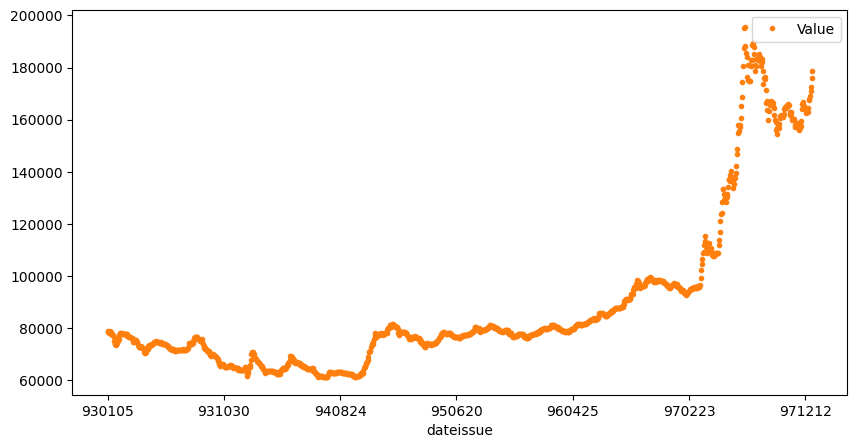

In [7]:
df['dateissue'] = df['dateissue'].apply(lambda x: str(x)[-6:])
df.plot( x="dateissue", y="Value", style='.', figsize=(10,5), color=color_pal[1])
clear_output()
plt.show()

In [8]:
df1['dateissue'] = df1['dateissue'].apply(lambda x: str(x)[-6:])
df2['dateissue'] = df2['dateissue'].apply(lambda x: str(x)[-6:])
clear_output()

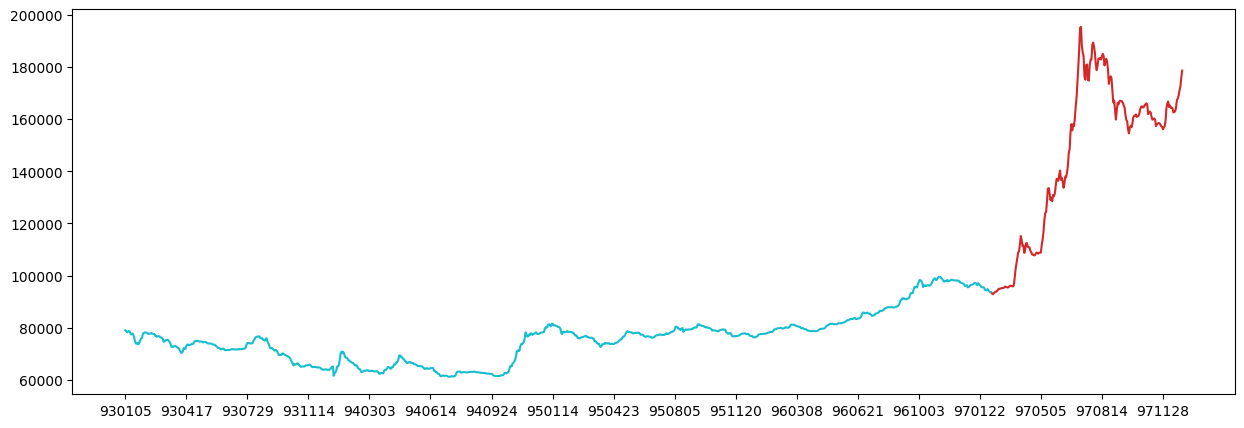

In [9]:
plt.plot(df2["dateissue"], df2["Value"], color=color_pal[9])
plt.plot(df1["dateissue"], df1["Value"], color=color_pal[3]) # after barjam (red)
plt.xticks(np.arange(0, len(df), step=70))
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

In [10]:
df.shape

(1213, 2)

In [11]:
df.index = df.pop("dateissue")
df

,Value
dateissue,
930105,79013.5
930106,78619.4
930109,78239.7
930110,78469.2
930111,78741.3
...,...
971222,169115.5
971225,171124.9
971226,172522.5


### preprocessing

In [12]:
# scaler = MinMaxScaler(feature_range=(0,1))
# dataset = scaler.fit_transform(dataset)
# dataset

# test_dataset = [i for i in dataset if i not in train_dataset]
# test_dataset

# df['Value'] = df['Value'] / 100000

df_mean = df['Value'].mean()
df['Value'] = df['Value'] / df_mean
clear_output()
df

,Value
dateissue,
930105,0.890553
930106,0.886111
930109,0.881832
930110,0.884418
930111,0.887485
...,...
971222,1.906084
971225,1.928732
971226,1.944484


In [13]:
dataset = df.values

### split train and test datasets  

In [14]:
train_count = math.ceil(len(dataset) * 0.80) # find 80% of our dataset
print(train_count)
print(len(dataset)-train_count)
print(dataset.shape)

971
242
(1213, 1)


In [15]:
train_dataset = dataset[0:train_count]
train_dataset = np.array(train_dataset)
train_dataset

array([[0.89055322],
       [0.88611136],
       [0.8818318 ],
       [0.88441847],
       [0.88748529],
       [0.88530324],
       [0.87501291],
       [0.87257727],
       [0.87707323],
       [0.872637  ],
       [0.86224411],
       [0.84442369],
       [0.83374676],
       [0.83232888],
       [0.83586344],
       [0.82996425],
       [0.83584991],
       [0.84571533],
       [0.85360383],
       [0.85636859],
       [0.87241384],
       [0.87826907],
       [0.88060778],
       [0.88083545],
       [0.88098198],
       [0.87844264],
       [0.87427466],
       [0.87646798],
       [0.87594388],
       [0.87633949],
       [0.87835248],
       [0.87613436],
       [0.87458123],
       [0.87473677],
       [0.86675247],
       [0.86771838],
       [0.86254955],
       [0.86373863],
       [0.86523991],
       [0.86452195],
       [0.86103136],
       [0.8589778 ],
       [0.85735254],
       [0.8530617 ],
       [0.84017118],
       [0.84234082],
       [0.84647612],
       [0.849

##### *we create a sequence(to make an iteratin on the dataset) for every data in the dataframe to use it for lstm and rnn  models in the future.*

In [16]:
x_train = []
y_train = []

for i in range(10,train_count):
    x_train.append(train_dataset[i-10:i, 0])
    y_train.append(train_dataset[i,0])
    if i<=10 : #we can get the first round of the train dataset which we created
        print(x_train)
        print(y_train)

[array([0.89055322, 0.88611136, 0.8818318 , 0.88441847, 0.88748529,
       0.88530324, 0.87501291, 0.87257727, 0.87707323, 0.872637  ])]
[0.8622441058512378]


In [17]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(961, 10)

In [18]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(961, 10, 1)

### create models: 
1. LSTM
2. CNN

In [19]:
lstm_model = Sequential()
nn_model = Sequential()

In [20]:
# model = Sequential([
#     layers.LSTM(50, return_sequences=True, input_shape=(10,1)),
#     layers.LSTM(50, return_sequences=False),
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(16, activation='relu'),
#     layers.Dropout(0.3),
#     layers.BatchNormalization(),
#     layers.Dense(1, activation='relu'),
# ])

lstm_model.add(LSTM(50, input_shape = (10,1), return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(256))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
# lstm_model.add(Activation("linear"))

# model.add(LSTM(50, return_sequences=True, input_shape=(10,1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(64))
# model.add(Dense(32))
# model.add(Dense(8))
# model.add(Dense(1))

In [21]:
nn_model.add(Dense(128,input_shape=(10,1)))
nn_model.add(Conv1D(filters = 112, kernel_size= 1,padding='valid', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=2, padding='valid'))
nn_model.add(Conv1D(filters = 64,kernel_size = 1,padding='valid', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=1, padding='valid'))
nn_model.add(Dropout(0.2))
nn_model.add(Flatten())
nn_model.add(Dense(100, activation="linear"))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1))

In [22]:
keras.utils.plot_model(lstm_model) 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
lstm_model.compile(loss="mse", optimizer="adam", metrics=['mae', 'accuracy'])
nn_model.compile(loss="mse", optimizer="adam", metrics=['mae', 'accuracy'])

In [24]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               314368    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [25]:
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10, 128)           256       
                                                                 
 conv1d (Conv1D)             (None, 10, 112)           14448     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 112)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 64)             7232      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)            

### fit models

In [26]:
lstm_history = lstm_model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
97/97 [==============================] - 8s 18ms/step - loss: 0.0273 - mae: 0.0954 - accuracy: 0.0000e+00
Epoch 2/10
97/97 [==============================] - 2s 16ms/step - loss: 0.0027 - mae: 0.0413 - accuracy: 0.0000e+00
Epoch 3/10
97/97 [==============================] - 2s 19ms/step - loss: 0.0024 - mae: 0.0391 - accuracy: 0.0000e+00
Epoch 4/10
97/97 [==============================] - 2s 16ms/step - loss: 0.0022 - mae: 0.0372 - accuracy: 0.0000e+00
Epoch 5/10
97/97 [==============================] - 1s 14ms/step - loss: 0.0019 - mae: 0.0352 - accuracy: 0.0000e+00
Epoch 6/10
97/97 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0387 - accuracy: 0.0000e+00
Epoch 7/10
97/97 [==============================] - 1s 14ms/step - loss: 0.0022 - mae: 0.0367 - accuracy: 0.0000e+00
Epoch 8/10
97/97 [==============================] - 1s 13ms/step - loss: 0.0019 - mae: 0.0349 - accuracy: 0.0000e+00
Epoch 9/10
97/97 [==============================] - 1s 13ms/step

In [27]:
nn_history = nn_model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
97/97 [==============================] - 2s 3ms/step - loss: 0.0275 - mae: 0.1091 - accuracy: 0.0000e+00
Epoch 2/10
97/97 [==============================] - 0s 3ms/step - loss: 0.0071 - mae: 0.0664 - accuracy: 0.0000e+00
Epoch 3/10
97/97 [==============================] - 0s 2ms/step - loss: 0.0055 - mae: 0.0584 - accuracy: 0.0000e+00
Epoch 4/10
97/97 [==============================] - 0s 3ms/step - loss: 0.0048 - mae: 0.0559 - accuracy: 0.0000e+00
Epoch 5/10
97/97 [==============================] - 0s 4ms/step - loss: 0.0055 - mae: 0.0590 - accuracy: 0.0000e+00
Epoch 6/10
97/97 [==============================] - 0s 5ms/step - loss: 0.0042 - mae: 0.0520 - accuracy: 0.0000e+00
Epoch 7/10
97/97 [==============================] - 0s 3ms/step - loss: 0.0038 - mae: 0.0488 - accuracy: 0.0000e+00
Epoch 8/10
97/97 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0451 - accuracy: 0.0000e+00
Epoch 9/10
97/97 [==============================] - 0s 2ms/step - loss: 

### create test array

In [28]:
test_dataset = dataset[train_count-10:,:]
x_test = []
y_test = dataset[train_count:,:]

for i in range(10,len(test_dataset)):
    x_test.append(test_dataset[i-10:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))
x_test.shape

(242, 10, 1)

In [29]:
lstm_predicts = lstm_model.predict(x_test)
print(f"lstm shape = {lstm_predicts.shape}")

nn_predicts = nn_model.predict(x_test)
print(f"cnn shape = {lstm_predicts.shape}")

8/8 [==============================] - 1s 10ms/step
lstm shape = (242, 1)
8/8 [==============================] - 0s 3ms/step
cnn shape = (242, 1)


In [30]:
print(nn_history.history.keys())
print(lstm_history.history.keys())

dict_keys(['loss', 'mae', 'accuracy'])
dict_keys(['loss', 'mae', 'accuracy'])


### Model Validation

In [31]:
print(f"Lstm model Last ephoc loss  = {lstm_history.history['loss'][-1]}")
print(f"CNN model Last ephoc loss  = {nn_history.history['loss'][-1]}")

Lstm model Last ephoc loss  = 0.001802722574211657
CNN model Last ephoc loss  = 0.0030438716057687998


In [32]:
lstm_test_loss, lstm_test_acc, _ = lstm_model.evaluate(x_test, y_test) 

8/8 [==============================] - 1s 9ms/step - loss: 0.0104 - mae: 0.0747 - accuracy: 0.0000e+00


In [33]:
cnn_test_loss, cnn_test_acc, _ = nn_model.evaluate(x_test, y_test) 

8/8 [==============================] - 0s 2ms/step - loss: 0.0047 - mae: 0.0503 - accuracy: 0.0000e+00


In [34]:
data = {'LSTM': [lstm_test_acc,math.sqrt(mean_squared_error(y_test, lstm_predicts)),mean_squared_error(y_test, lstm_predicts)],
        'CNN': [cnn_test_acc, math.sqrt(mean_squared_error(y_test, nn_predicts)),mean_squared_error(y_test, nn_predicts)]}
errors = pd.DataFrame(data, index=['acc',
                               'RSME',
                               'MSE'])
errors

,LSTM,CNN
acc,0.074718,0.050254
RSME,0.102077,0.068574
MSE,0.010420,0.004702


In [35]:
train = df[:train_count] * df_mean
validation = df[train_count:] * df_mean
validation[['predictions(lstm)']] = lstm_predicts * df_mean
validation[['predictions(nn)']] = nn_predicts * df_mean
clear_output()
validation

,Value,predictions(lstm),predictions(nn)
dateissue,,,
970106,96489.7,97631.882812,97455.250000
970107,96596.6,97598.351562,97396.000000
970108,96938.8,97612.929688,97436.187500
970114,97086.1,97696.015625,97501.554688
970115,97150.5,97796.117188,97633.851562
...,...,...,...
971222,169115.5,157335.171875,167903.078125
971225,171124.9,157617.890625,168693.140625
971226,172522.5,158124.437500,169297.437500


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


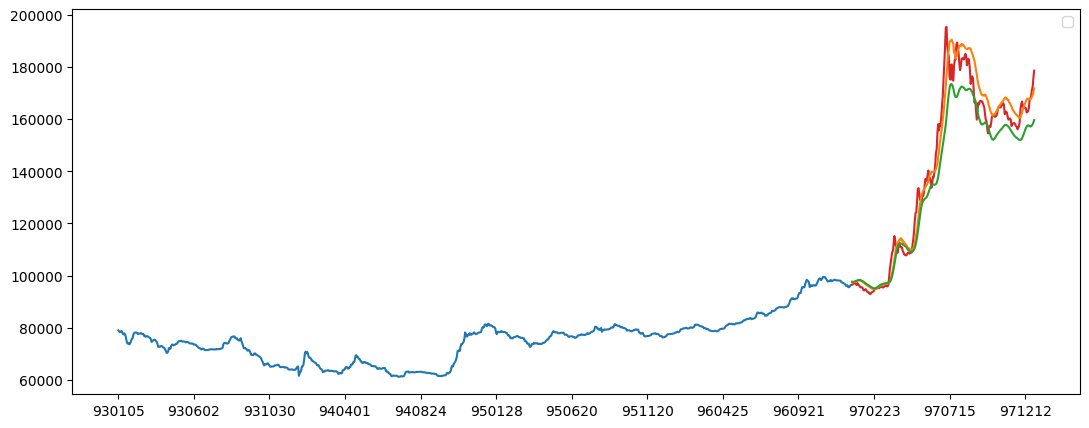

In [36]:
plt.figure(figsize=(12,5))
plt.plot(train["Value"], color=color_pal[0])
plt.plot(validation[["Value"]], color =color_pal[3])
plt.plot(validation[["predictions(nn)"]], color=color_pal[1])
plt.plot(validation[["predictions(lstm)"]], color=color_pal[2])
plt.xticks(np.arange(0, len(df), step=100))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(13, 5)
plt.savefig('models-validation-(93-98)')
plt.show()

# blue = training 
# red = original validation
# orange = predictions using CNN
# green = predictions using LSTM